In [118]:
!pip install ffmpeg moviepy

In [119]:
!pip install tensorflow opencv-python-headless


In [120]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
import tensorflow_hub as hub
from google.colab.patches import cv2_imshow
import imageio

In [123]:
# Load the MoveNet model from TensorFlow Hub
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

In [124]:
# Define the mapping of keypoints to hand parts
keypoint_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'open_hand', 'close_hand', 'thumb', 'index',
                  'middle', 'ring', 'pinky']
# Define the connections between keypoints to draw lines for visualization
connections = [(0, 1), (0, 2), (1, 3), (2, 4), (0, 5), (0, 6), (5, 7), (7, 9), (6, 8), (8, 10),
               (5, 6), (5, 11), (6, 12), (11, 12)]


In [125]:
# Function to perform pose detection on an image sequence or GIF
def detect_pose_sequence(video_path):
    # Load the GIF
    gif = cv2.VideoCapture(video_path)
    frames = []
    # Read frames from the GIF
    while True:
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    # Initialize an empty list to store keypoints for each frame
    all_keypoints = []
    # Iterate through each frame
    for frame in frames:
        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resize frame to the expected input size of MoveNet
        frame_resized = tf.image.resize_with_pad(tf.expand_dims(frame_rgb, axis=0), 192, 192) # 192 for lightning
        # Convert the resized frame tensor to a NumPy array with dtype uint8
        frame_np = frame_resized.numpy().astype(np.int32)
        # Perform inference
        outputs = movenet.signatures["serving_default"](tf.constant(frame_np))
        # Extract the keypoints
        keypoints = outputs['output_0'].numpy()
        # Append keypoints to the list
        all_keypoints.append(keypoints)
    # Return keypoints for all frames
    return all_keypoints

In [135]:
# Function to visualize keypoints on an image sequence or GIF and create a new GIF
def visualize_and_create_pose_sequence(video_path, keypoints_list, output_video_path, default_fps=10):
    # Load the GIF
    video = imageio.get_reader(video_path)
    # Initialize list to store frames with keypoints overlay
    frames_with_keypoints = []
    # Loop through each frame and its corresponding keypoints
    for frame_index, (frame, keypoints) in enumerate(zip(video, keypoints_list)):
        # Convert keypoints to numpy array
        keypoints = np.array(keypoints)
        # Ensure keypoints array has the expected shape
        if keypoints.shape == (1, 1, 17, 3):
            # Extract keypoints from the array
            keypoints = keypoints[0, 0]
            # Loop through each keypoint
            for kp_index, kp in enumerate(keypoints):
                # Extract x and y coordinates of the keypoint
                x = int(kp[1] * frame.shape[1])
                y = int(kp[0] * frame.shape[0])
                # Check if the keypoint is critical
                if keypoint_names[kp_index] in ['open_hand', 'close_hand', 'thumb', 'index',
'middle', 'ring', 'pinky']:
                    # Calculate the average position of neighboring keypoints
                    neighbor_indices = [0, 1, 5, 6]
                    neighbor_positions = []
                    for connection in neighbor_indices:
                        neighbor_kp_index = connection[0] if connection[1] == kp_index else connection[1]
                        neighbor_positions.append(keypoints[neighbor_kp_index])
                    neighbor_positions = np.array(neighbor_positions)
                    average_x = int(np.mean(neighbor_positions[:, 1]) * frame.shape[1])
                    average_y = int(np.mean(neighbor_positions[:, 0]) * frame.shape[0])
                    # Update the position of the critical keypoint
                    x = average_x
                    y = average_y
                # Draw a circle at the adjusted keypoint position
                cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)  # Increase thickness and change color to blue
            # Draw lines connecting keypoints
            for connection in connections:
                start_point = (int(keypoints[connection[0], 1] * frame.shape[1]),
                               int(keypoints[connection[0], 0] * frame.shape[0]))
                end_point = (int(keypoints[connection[1], 1] * frame.shape[1]),
                             int(keypoints[connection[1], 0] * frame.shape[0]))
                cv2.line(frame, start_point, end_point, (0, 0, 255), 1)  # Increase thickness and change color to red
            # Append the frame with keypoints overlay to the list
            frames_with_keypoints.append(frame)
        else:
            print("Unexpected shape of keypoints array for frame", frame_index + 1)
    # Remove the last frame if it's a black frame
    if np.all(frames_with_keypoints[-1] == [0, 0, 0]):
        frames_with_keypoints.pop()
    # Get the frame rate from the metadata if available, otherwise use the default frame rate
    try:
        fps = video.get_meta_data()['fps']
    except KeyError:
        fps = default_fps
    # Save the frames with keypoints overlay as a new GIF
    imageio.mimsave(output_video_path, frames_with_keypoints, fps=fps)

In [136]:
import gdown

# URL to the Google Drive file
url = "https://drive.google.com/uc?id=1QJS0yZMu8zNGRyJr_jDUuIW1WT4kpZBM"
output = "temp_video.mp4"

# Download the file
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1QJS0yZMu8zNGRyJr_jDUuIW1WT4kpZBM
To: /content/temp_video.mp4
100%|██████████| 562k/562k [00:00<00:00, 83.7MB/s]


'temp_video.mp4'

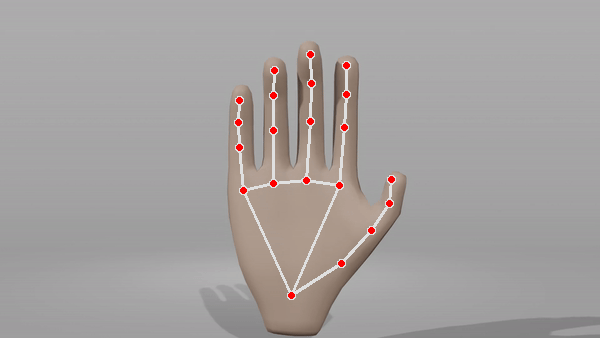

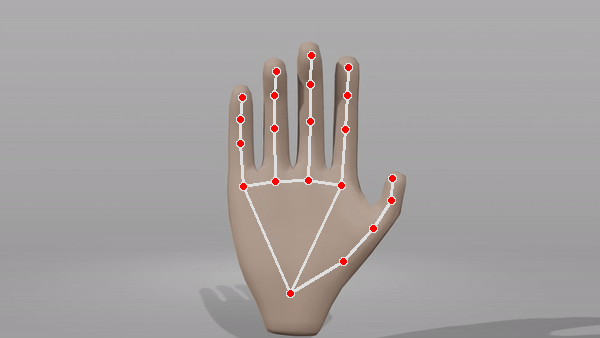

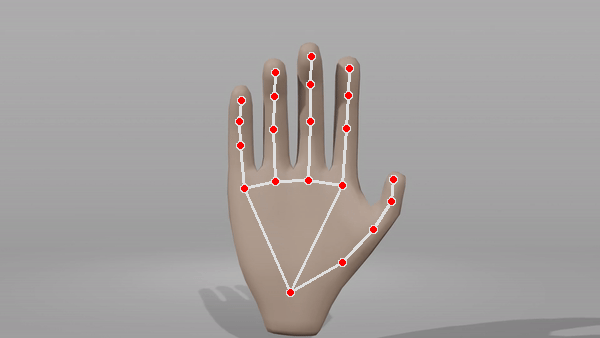

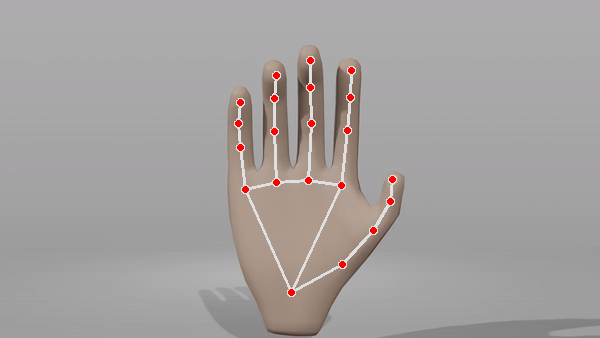

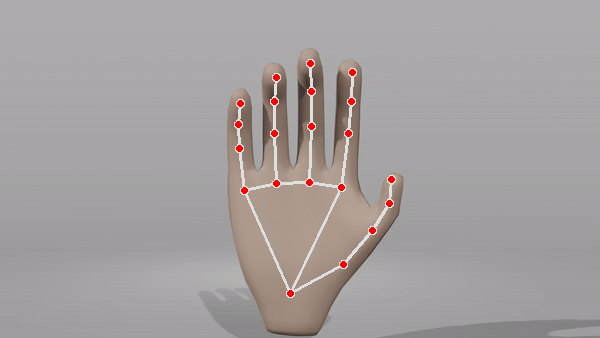

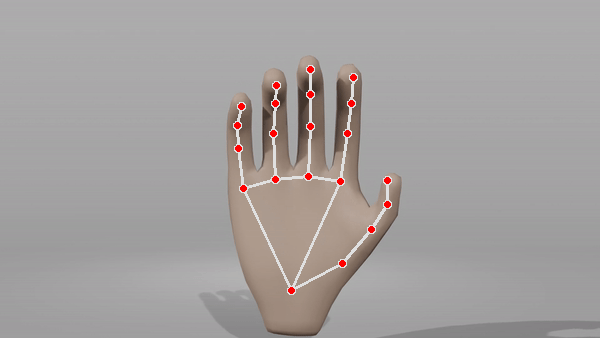

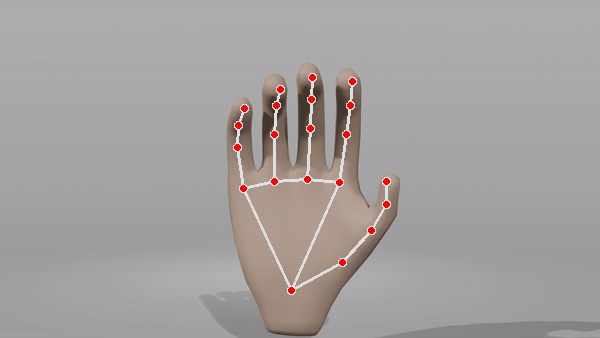

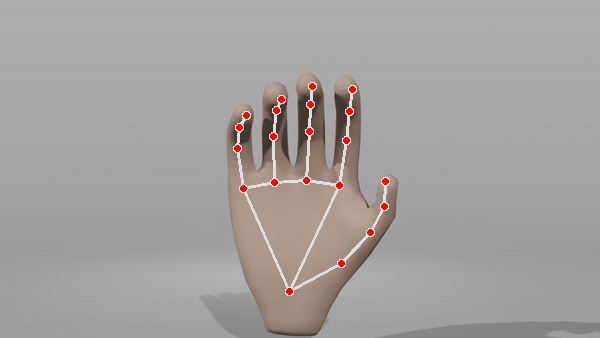

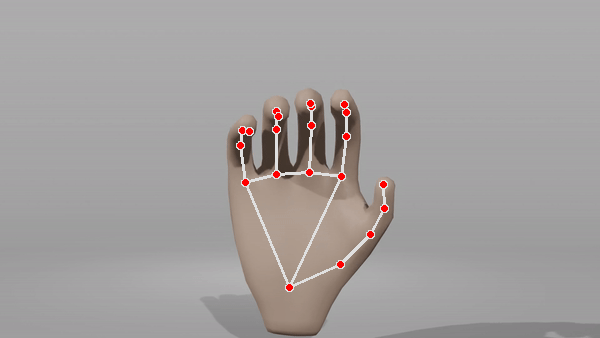

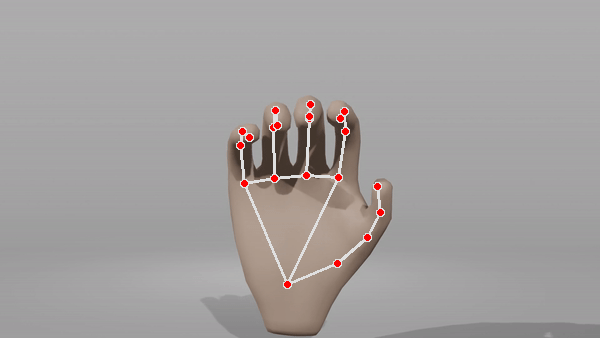

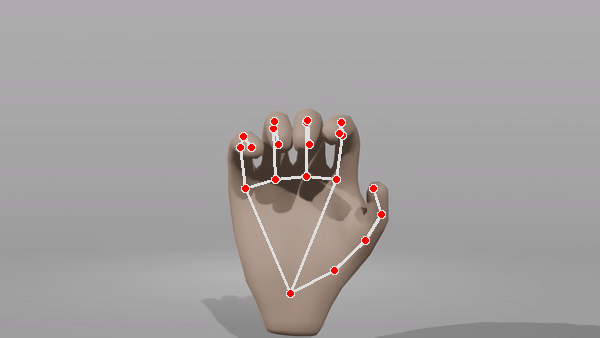

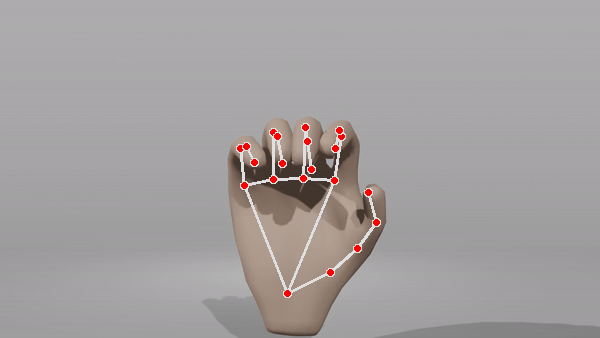

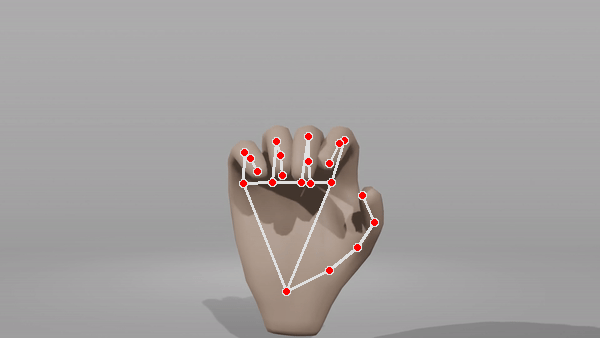

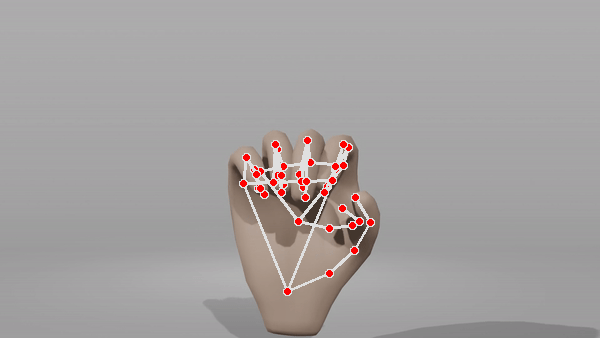

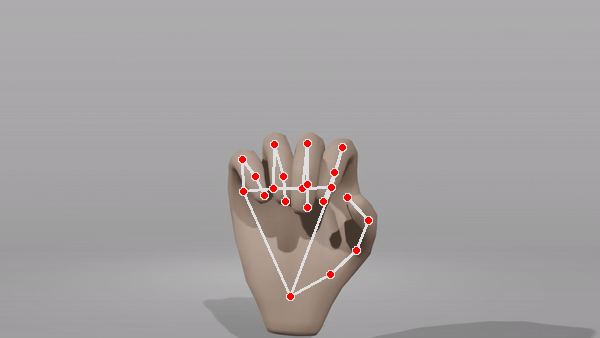

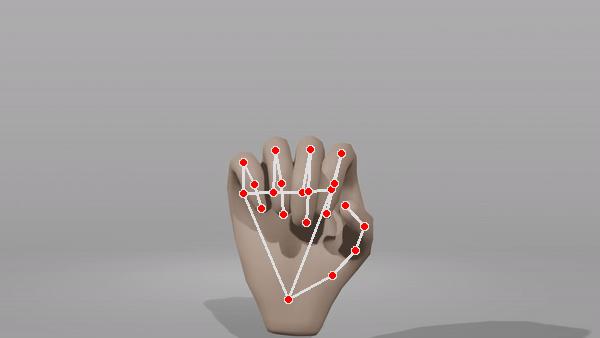

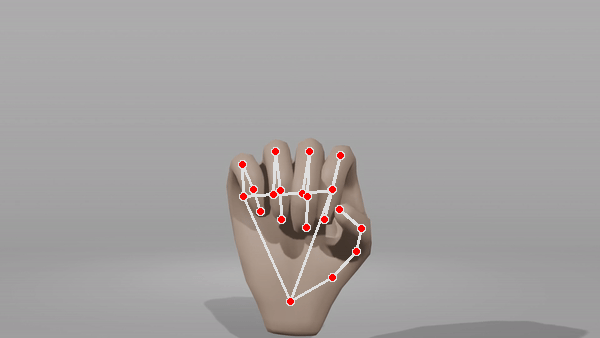

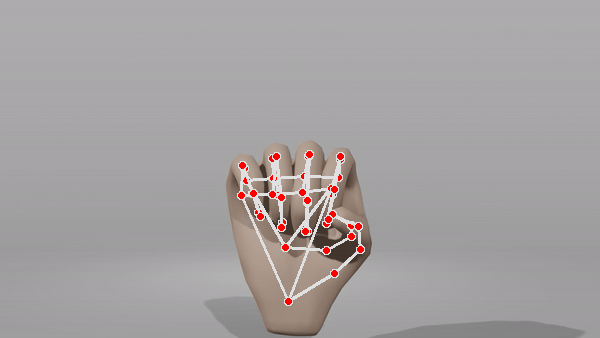

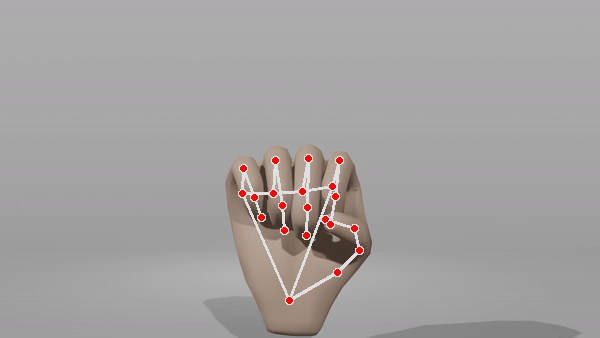

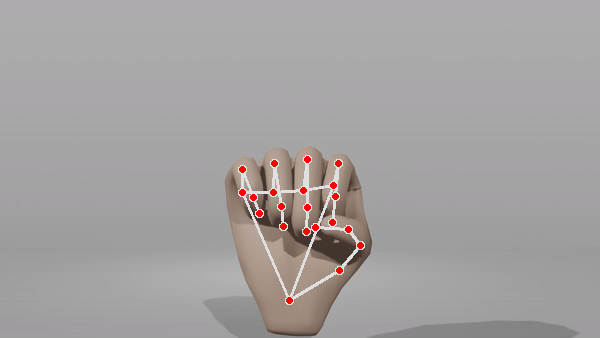

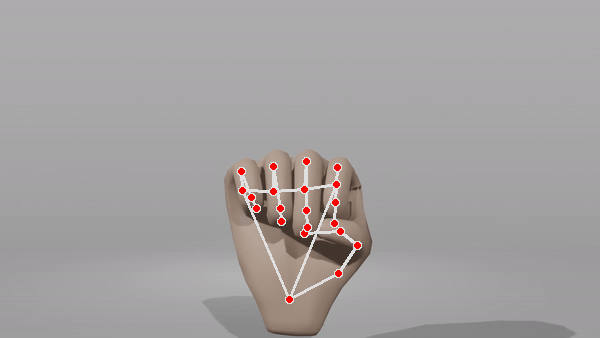

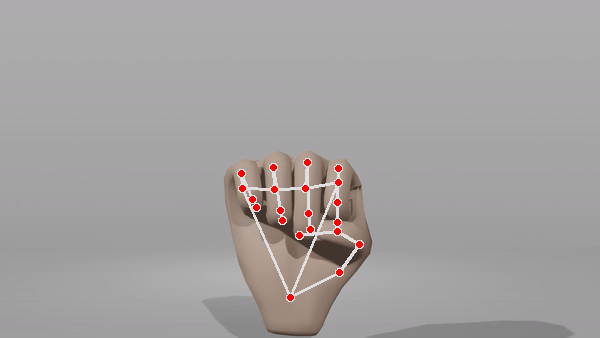

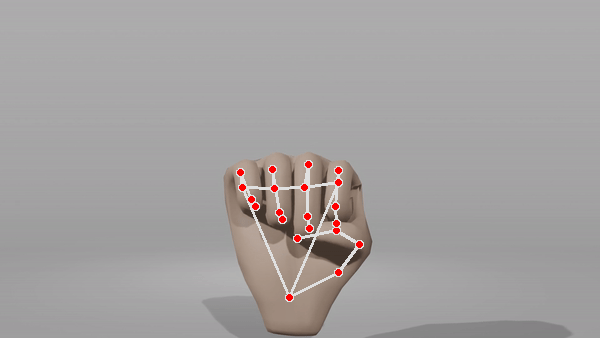

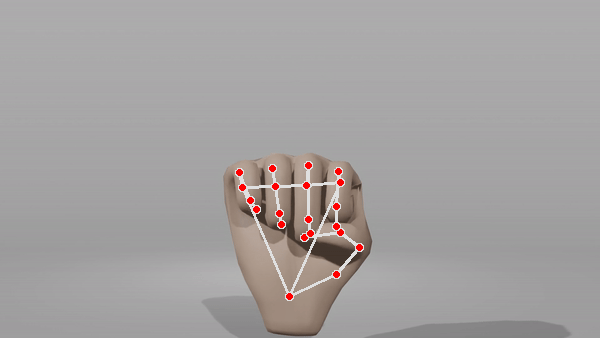

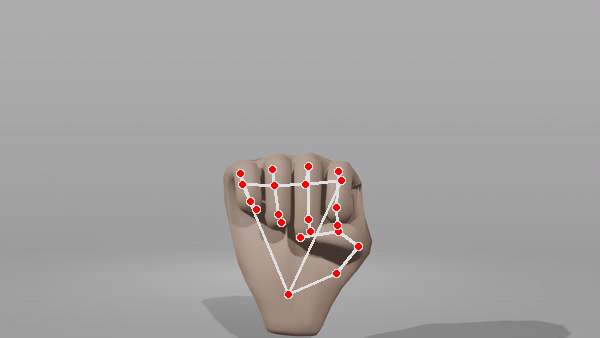

In [139]:
from PIL import Image
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow # Import the Colab patch for cv2.imshow

# Load the GIF
gif = Image.open("temp_video.mp4")

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

# Process each frame of the GIF
try:
    while True:
        # Convert PIL image to an OpenCV image
        frame = cv2.cvtColor(np.array(gif.convert("RGB")), cv2.COLOR_RGB2BGR)

        # Convert the BGR image to RGB for MediaPipe
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Process the image and detect hands
        results = hands.process(image)

        # Convert the image color back to BGR for OpenCV
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                # Draw hand landmarks on the image
                mp_drawing.draw_landmarks(
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Display the image with landmarks using the Colab patch
        cv2_imshow(image)

        # Move to the next frame in the GIF
        gif.seek(gif.tell() + 1)

        if cv2.waitKey(5) & 0xFF == 27:
            break

except EOFError:
    pass

# Release resources
cv2.destroyAllWindows()